# Imports

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import colors
%matplotlib inline 
import math
import time
import heapq

# Vision Pipeline

In [2]:
map_raw = cv2.imread('Final_map.jpg')

## 1. Goal Detection

In [3]:
def find_goal(map_raw):
    # WRITE CODE TO TAKE PICTURE (named map_raw)
    # Code Here:
    
    # Values for detecting the color red
    low_red = np.array([150, 100, 50])
    high_red = np.array([200, 255, 255])
    
    # Convert image to HSV
    map_hsv = cv2.cvtColor(map_raw, cv2.COLOR_BGR2HSV)
    
    # Apply mask to image to get the goal (red circle)
    mask = cv2.inRange(map_hsv, low_red, high_red)
    map_mask_goal = cv2.bitwise_and(map_raw, map_raw, mask=mask)
    
    # Convert image to gray
    gray_goal = cv2.cvtColor(map_mask_goal, cv2.COLOR_BGR2GRAY)
    
    # Detect circles
    circles = cv2.HoughCircles(gray_goal, cv2.HOUGH_GRADIENT, 
                               1, 20, param1=100, param2=10, 
                               minRadius=20, maxRadius=100)
    
    # Output
    if circles is None:
        print("Warning: No goal found, take another picture.")
        find_goal(map_raw) # Remove argument when code is modified
    else:
        return [circles[0, 0, 0], circles[0, 0, 1]]


## 2. Thymio Detection

In [4]:
def find_thymio(map_raw):
    # WRITE CODE TO TAKE PICTURE (named map_raw)
    # Code Here:
    
    
    # Values for detecting the color green
    low_green = np.array([10, 100, 50])
    high_green = np.array([130, 255, 255])
    
    # Convert image to HSV
    map_hsv = cv2.cvtColor(map_raw, cv2.COLOR_BGR2HSV)
    
    # Apply mask to image to get the goal (red circle)
    mask = cv2.inRange(map_hsv, low_green, high_green)
    map_mask_thymio = cv2.bitwise_and(map_raw, map_raw, mask=mask)
    
    # Convert image to gray
    gray_thymio = cv2.cvtColor(map_mask_thymio, cv2.COLOR_BGR2GRAY)
    
    # Detect circles
    circles = cv2.HoughCircles(gray_thymio, cv2.HOUGH_GRADIENT, 
                               1, 20, param1=100, param2=10, 
                               minRadius=0, maxRadius=100)
    
    # Output
    if circles.shape[1]<2:
        print("Warning: No thymio found, take another picture.")
        find_thymio(map_raw) # Remove argument when code is modified
    else:
        if circles[0][0][2] > circles[0][1][2]:
            xp,yp,rp = circles[0][1]
            xg,yg,rg = circles[0][0]
        else:
            xp,yp,rp = circles[0][0]
            xg,yg,rg = circles[0][1]
            
        direction = [xp-xg,yp-yg]
        
        thymio_x = xg
        thymio_y = yg
        thymio_theta = np.arctan2(direction[1], direction[0])
              
        return [thymio_x, thymio_y, thymio_theta]

## 3. Occupancy Grid

In [5]:
 def preprocessing(map_raw):
    # Convert to RGB
    map_rgb = cv2.cvtColor(map_raw, cv2.COLOR_BGR2RGB)
    
    # Blur Image
    map_blur = cv2.blur(map_rgb,(10,10))
    
    # Convert to RGB
    map_rgb = cv2.cvtColor(map_blur, cv2.COLOR_BGR2RGB)
    
    # Apply Bilateral filter
    map_bilateral = cv2.bilateralFilter(map_rgb,5,15,15)
    
    # Create Binary Image
    map_gray = cv2.cvtColor(map_bilateral, cv2.COLOR_RGB2GRAY)
    _, map_binary = cv2.threshold(map_gray, 70, 255, cv2.THRESH_BINARY_INV)
        
    # Opening to remove noise
    kernel_morph = np.ones((10,10),np.uint8)
    map_clean = cv2.morphologyEx(map_binary, cv2.MORPH_OPEN, kernel_morph)
    
    kernel_erode = np.ones((60,60),np.uint8)
    kernel_dilate = np.ones((140,140),np.uint8)
    map_obstacle = cv2.erode(map_clean, kernel_erode, iterations=1) 
    map_occupancy = cv2.dilate(map_obstacle, kernel_dilate, iterations=1) 

    return map_occupancy


def create_empty_plot(max_width, max_height):
    """
    Helper function to create a figure of the desired dimensions & grid
    
    :param max_val: dimension of the map along the x and y dimensions
    :return: the fig and ax objects.
    """
    fig, ax = plt.subplots(figsize=(9,9))
    
    major_ticks_x = np.arange(0, max_width+1, 5)
    minor_ticks_x = np.arange(0, max_width+1, 1)
    major_ticks_y = np.arange(0, max_height+1, 5)
    minor_ticks_y = np.arange(0, max_height+1, 1)
    ax.set_xticks(major_ticks_x)
    ax.set_xticks(minor_ticks_x, minor=True)
    ax.set_yticks(major_ticks_y)
    ax.set_yticks(minor_ticks_y, minor=True)
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    ax.set_ylim([-1,max_height])
    ax.set_xlim([-1,max_width])
    ax.grid(True)
    
    return fig, ax

def create_occupancy_grid(map_raw, grid_size):
    
    map_occupancy = preprocessing(map_raw)

    height = grid_size # Size of the grid
    width = round(map_occupancy.shape[1]/map_occupancy.shape[0]*height)

    fig, ax = create_empty_plot(width,height)
    
    occupancy_grid = np.zeros((height,width))
    n = round(map_occupancy.shape[0]/height)

    for i in range(height):
        for j in range(width):
            result = np.sum(map_occupancy[n*i:n*(i+1),n*j:n*(j+1)])
            if result > 0 : 
                occupancy_grid[height-1-i,j] = 1
                
    return occupancy_grid, n

Goal Detection Time: 0.04139876365661621 s
Thymio Detection Time: 0.01390695571899414 s
Occupancy Grid Time: 0.14255475997924805


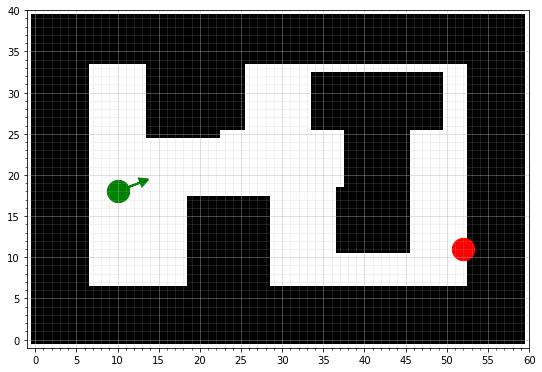

In [6]:
map_raw = cv2.imread('Final_map.jpg')
grid_size = 40
cmap = colors.ListedColormap(['white', 'black']) # Select the colors with which to display obstacles and free cells

start = time.time()
goal_pos = find_goal(map_raw)
end = time.time()
print("Goal Detection Time:", end - start, "s")

start = time.time()
thymio_pos = find_thymio(map_raw)
end = time.time()
print("Thymio Detection Time:", end - start, "s")

start = time.time()
occupancy_grid, ratio = create_occupancy_grid(map_raw, grid_size)
end = time.time()
print("Occupancy Grid Time:", end - start)

goal_pos_grid = [round(goal_pos[0]/ratio), round(grid_size-goal_pos[1]/ratio)]
thymio_pos_grid = [round(thymio_pos[0]/ratio), round(grid_size-thymio_pos[1]/ratio), -thymio_pos[2]]

plt.imshow(occupancy_grid, cmap=cmap)
plt.scatter(goal_pos_grid[0], goal_pos_grid[1], marker="o", color='red', s=500);
plt.scatter(thymio_pos_grid[0], thymio_pos_grid[1], marker="o", color='green', s=500);
plt.arrow(thymio_pos_grid[0], thymio_pos_grid[1], 3*math.cos(thymio_pos_grid[2]),
         3*math.sin(thymio_pos_grid[2]), head_width=1, head_length=1, fc='g', ec='g', lw=2)

# A*

In [7]:
def _get_movements_4n():
    """
    Get all possible 4-connectivity movements (up, down, left right).
    :return: list of movements with cost [(dx, dy, movement_cost)]
    """
    return [(1, 0, 1.0),
            (0, 1, 1.0),
            (-1, 0, 1.0),
            (0, -1, 1.0)]

def _get_movements_8n():
    """
    Get all possible 8-connectivity movements. Equivalent to get_movements_in_radius(1)
    (up, down, left, right and the 4 diagonals).
    :return: list of movements with cost [(dx, dy, movement_cost)]
    """
    s2 = math.sqrt(2)
    return [(1, 0, 1.0),
            (0, 1, 1.0),
            (-1, 0, 1.0),
            (0, -1, 1.0),
            (1, 1, s2),
            (-1, 1, s2),
            (-1, -1, s2),
            (1, -1, s2)]

def reconstruct_path(cameFrom, current):
    """
    Recurrently reconstructs the path from start node to the current node
    :param cameFrom: map (dictionary) containing for each node n the node immediately 
                     preceding it on the cheapest path from start to n 
                     currently known.
    :param current: current node (x, y)
    :return: list of nodes from start to current node
    """
    total_path = [current]
    while current in cameFrom.keys():
        # Add where the current node came from to the start of the list
        total_path.insert(0, cameFrom[current]) 
        current=cameFrom[current]
    return total_path

def A_Star(start, goal, h, coords, occupancy_grid, movement_type="4N"):#, max_val=max_val):
    """
    A* for 2D occupancy grid. Finds a path from start to goal.
    h is the heuristic function. h(n) estimates the cost to reach goal from node n.
    :param start: start node (x, y)
    :param goal_m: goal node (x, y)
    :param occupancy_grid: the grid map
    :param movement: select between 4-connectivity ('4N') and 8-connectivity ('8N', default)
    :return: a tuple that contains: (the resulting path in meters, the resulting path in data array indices)
    """
    
    # -----------------------------------------
    # DO NOT EDIT THIS PORTION OF CODE
    # -----------------------------------------
    
    # Check if the start and goal are within the boundaries of the map
    #for point in [start, goal]:
    #    for coord in point:
    #        assert coord>=0 and coord<max_val, "start or end goal not contained in the map"
    
    # check if start and goal nodes correspond to free spaces
    if occupancy_grid[start[0], start[1]]:
        raise Exception('Start node is not traversable')

    if occupancy_grid[goal[0], goal[1]]:
        raise Exception('Goal node is not traversable')
    
    # get the possible movements corresponding to the selected connectivity
    if movement_type == '4N':
        movements = _get_movements_4n()
    elif movement_type == '8N':
        movements = _get_movements_8n()
    else:
        raise ValueError('Unknown movement')
    
    # --------------------------------------------------------------------------------------------
    # A* Algorithm implementation - feel free to change the structure / use another pseudo-code
    # --------------------------------------------------------------------------------------------
    
    # The set of visited nodes that need to be (re-)expanded, i.e. for which the neighbors need to be explored
    # Initially, only the start node is known.
    openSet = [start]
    
    # The set of visited nodes that no longer need to be expanded.
    closedSet = []

    # For node n, cameFrom[n] is the node immediately preceding it on the cheapest path from start to n currently known.
    cameFrom = dict()

    # For node n, gScore[n] is the cost of the cheapest path from start to n currently known.
    gScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    gScore[start] = 0

    # For node n, fScore[n] := gScore[n] + h(n). map with default value of Infinity
    fScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    fScore[start] = h[start]

    # while there are still elements to investigate
    while openSet != []:
        
        #the node in openSet having the lowest fScore[] value
        fScore_openSet = {key:val for (key,val) in fScore.items() if key in openSet}
        current = min(fScore_openSet, key=fScore_openSet.get)
        del fScore_openSet
        
        #If the goal is reached, reconstruct and return the obtained path
        if current == goal:
            return reconstruct_path(cameFrom, current), closedSet

        openSet.remove(current)
        closedSet.append(current)
        
        #for each neighbor of current:
        for dx, dy, deltacost in movements:
            
            neighbor = (current[0]+dx, current[1]+dy)
            
            # if the node is not in the map, skip
            if (neighbor[0] >= occupancy_grid.shape[0]) or (neighbor[1] >= occupancy_grid.shape[1]) or (neighbor[0] < 0) or (neighbor[1] < 0):
                continue
            
            # if the node is occupied or has already been visited, skip
            if (occupancy_grid[neighbor[0], neighbor[1]]) or (neighbor in closedSet): 
                continue
                
            # d(current,neighbor) is the weight of the edge from current to neighbor
            # tentative_gScore is the distance from start to the neighbor through current
            tentative_gScore = gScore[current] + deltacost
            
            if neighbor not in openSet:
                openSet.append(neighbor)
            
            if tentative_gScore < gScore[neighbor]:
                # This path to neighbor is better than any previous one. Record it!
                cameFrom[neighbor] = current
                gScore[neighbor] = tentative_gScore
                fScore[neighbor] = gScore[neighbor] + h[neighbor]

    # Open set is empty but goal was never reached
    print("No path found to goal")
    return [], closedSet

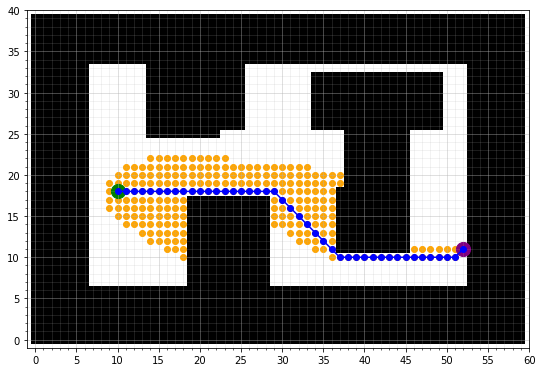

In [8]:
start = thymio_pos_grid[0], thymio_pos_grid[1]
goal = goal_pos_grid[0], goal_pos_grid[1]


# List of all coordinates in the grid
x,y = np.mgrid[0:60:1, 0:60:1]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
pos = np.reshape(pos, (x.shape[0]*x.shape[1], 2))
coords = list([(int(x[0]), int(x[1])) for x in pos])

# Define the heuristic, here = distance to goal ignoring obstacles
h = np.linalg.norm(pos - goal, axis=-1)
h = dict(zip(coords, h))

# Run the A* algorithm
occupancy_grid = occupancy_grid.transpose()
path, visitedNodes = A_Star(start, goal, h, coords, occupancy_grid, movement_type="8N")
path = np.array(path).reshape(-1, 2).transpose()
visitedNodes = np.array(visitedNodes).reshape(-1, 2).transpose()

# Displaying the map
fig_astar, ax_astar = create_empty_plot(60, 40)
ax_astar.imshow(occupancy_grid.transpose(), cmap=cmap)

# Plot the best path found and the list of visited nodes
ax_astar.scatter(visitedNodes[0], visitedNodes[1], marker="o", color = 'orange');
ax_astar.plot(path[0], path[1], marker="o", color = 'blue');
ax_astar.scatter(start[0], start[1], marker="o", color = 'green', s=200);
ax_astar.scatter(goal[0], goal[1], marker="o", color = 'purple', s=200);